### Initial package imports

In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List, Union
import random
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

## Initial files being read in and dataset creation

In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### Government bond column calculation

In [3]:
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000 # Initial value for the bond component

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
if len(main_df) > 0:
    interest_bond_vector[0] = interest_bond
    # Calculate initial daily rate for day 0
    daily_rate_0 = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[0] + 1.5) / days_per_annum) * (7/5)) / 100
    daily_rates[0] = daily_rate_0

# Calculate bond values day by day based on the daily yield rate
for i in range(1, len(main_df)):
    # Adding 1.5% to account for the credit risk spread, adjusted for weekends/holidays (7/5)
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / days_per_annum) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    previous_value = interest_bond_vector[i-1]
    current_value = previous_value * (1 + daily_rate)
    interest_bond_vector[i] = current_value
    
    # Calculate change, profit/loss
    change = current_value - previous_value
    interest_bond_profit_vector[i] = change
    interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates

## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**: 1 day  

#### Methods:
- **Variance-Covariance (Normal)**
- **Variance-Covariance (T-distribution)**
- **Historical Simulation**
- **GARCH(1,1)-Normal**
- **EWMA Filtered Historical Simulation (FHS)**

### Weights and Currency Correction

In [4]:
# Define weights 
weights_dict = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}
weights_array = np.array(list(weights_dict.values())) # Order: SP500, DAX40, NIKKEI, EU-BOND
asset_return_cols = ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the initial invested amounts in local currency
invested_amount_SP500_local = starting_investment * weights_dict['S&P500'] / usd_to_eur
invested_amount_DAX40_local = starting_investment * weights_dict['DAX40']
invested_amount_NIKKEI_local = starting_investment * weights_dict['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND_local = starting_investment * weights_dict['EU-BOND'] # Bond is already in EUR terms

print(f"Initial SP500 (USD): {invested_amount_SP500_local:.2f}")
print(f"Initial DAX40 (EUR): {invested_amount_DAX40_local:.2f}")
print(f"Initial NIKKEI (JPY): {invested_amount_NIKKEI_local:.2f}")
print(f"Initial EU_BOND (EUR): {invested_amount_EU_BOND_local:.2f}")

Initial SP500 (USD): 5177993.53
Initial DAX40 (EUR): 3000000.00
Initial NIKKEI (JPY): 148957298.91
Initial EU_BOND (EUR): 1500000.00


### Calculate Investment Values and Portfolio Metrics

In [5]:
# Create columns to track investments for each asset in local currency
start_idx = main_df[main_df['Date'] == starting_date].index[0]

main_df.loc[start_idx, 'SP500_Investment'] = invested_amount_SP500_local
main_df.loc[start_idx, 'DAX40_Investment'] = invested_amount_DAX40_local
main_df.loc[start_idx, 'NIKKEI_Investment'] = invested_amount_NIKKEI_local
# EU Bond investment value is tracked by 'Interest_Bond' column, starting from its initial value
main_df.loc[start_idx, 'EU_BOND_Investment'] = main_df.loc[start_idx, 'Interest_Bond']

# Calculate daily investment values for subsequent days
for i in range(start_idx + 1, len(main_df)):
    # S&P 500 in USD
    main_df.loc[i, 'SP500_Investment'] = main_df.loc[i-1, 'SP500_Investment'] * (1 + main_df.loc[i, 'C_S&P500_Returns'])
    # DAX 40 in EUR
    main_df.loc[i, 'DAX40_Investment'] = main_df.loc[i-1, 'DAX40_Investment'] * (1 + main_df.loc[i, 'C_Dax40_Returns'])
    # NIKKEI in JPY
    main_df.loc[i, 'NIKKEI_Investment'] = main_df.loc[i-1, 'NIKKEI_Investment'] * (1 + main_df.loc[i, 'C_Nikkei_Returns'])
    # EU Government Bond value is already calculated in the Interest_Bond column
    main_df.loc[i, 'EU_BOND_Investment'] = main_df.loc[i, 'Interest_Bond']

# Calculate total portfolio value in EUR for each day
main_df['Portfolio_Value_EUR'] = (
    main_df['SP500_Investment'].fillna(0) * main_df['USD/EUR'] +
    main_df['DAX40_Investment'].fillna(0) +
    main_df['NIKKEI_Investment'].fillna(0) * main_df['JPY/EUR'] +
    main_df['EU_BOND_Investment'].fillna(0)
)

# Ensure the first day's value is exactly the starting investment
main_df.loc[start_idx, 'Portfolio_Value_EUR'] = starting_investment

# Calculate the daily change in portfolio value (profit/loss) in EUR
main_df['Portfolio_Change_EUR'] = main_df['Portfolio_Value_EUR'].diff()
main_df.loc[start_idx, 'Portfolio_Change_EUR'] = 0.0  # Set the first day's change to 0

# Portfolio loss is the negative of the daily change
main_df['Portfolio_loss'] = -main_df['Portfolio_Change_EUR']
main_df.loc[start_idx, 'Portfolio_loss'] = 0.0

# Calculate Portfolio Daily Returns (weighted average of component returns in EUR)
# Note: This requires converting returns to EUR first or calculating based on EUR value changes.
# Simpler approach: Calculate return based on Portfolio_Value_EUR change
main_df['Portfolio_Daily_Return'] = main_df['Portfolio_Value_EUR'].pct_change()
main_df.loc[start_idx, 'Portfolio_Daily_Return'] = 0.0

# Display the relevant columns to verify
display(main_df[['Date', 'SP500_Investment', 'DAX40_Investment', 'NIKKEI_Investment', 
                'EU_BOND_Investment', 'USD/EUR', 'JPY/EUR', 'Portfolio_Value_EUR', 
                'Portfolio_Change_EUR', 'Portfolio_loss', 'Portfolio_Daily_Return']].head())
display(main_df[['Date', 'Portfolio_Value_EUR', 'Portfolio_Change_EUR', 'Portfolio_loss', 'Portfolio_Daily_Return']].tail())

,Date,SP500_Investment,DAX40_Investment,NIKKEI_Investment,EU_BOND_Investment,USD/EUR,JPY/EUR,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss,Portfolio_Daily_Return
0,2012-01-04,5177993.527508,3000000.000000,148957298.907646,1500000.000000,0.772500,0.010070,10000000.000000,0.000000,0.000000,0.000000
1,2012-01-05,5189897.180583,2992352.262000,148944672.531480,1500246.523142,0.782100,0.010120,10058937.456095,58937.456095,-58937.456095,0.005894
2,2012-01-06,5179533.786296,2973606.159562,148926948.770209,1500493.291886,0.786100,0.010210,10066275.107800,7337.651706,-7337.651706,0.000729
3,2012-01-09,5188699.359796,2953565.582481,148926948.770209,1500738.323863,0.783300,0.010190,10036177.722841,-30097.384960,30097.384960,-0.002990
4,2012-01-10,5224622.209432,3024254.466714,148932709.395941,1500982.736072,0.782600,0.010190,10131650.852632,95473.129791,-95473.129791,0.009513


,Date,Portfolio_Value_EUR,Portfolio_Change_EUR,Portfolio_loss,Portfolio_Daily_Return
2800,2022-12-23,19071881.240446,61319.273959,-61319.273959,0.003226
2801,2022-12-27,19035423.591491,-36457.648954,36457.648954,-0.001912
2802,2022-12-28,18857388.345751,-178035.245741,178035.245741,-0.009353
2803,2022-12-29,NaN,NaN,NaN,0.000000
2804,2022-12-30,NaN,NaN,NaN,0.000000


## Helper Functions for VaR/ES Calculation

### Basic VaR/ES (Normal & T-dist)

In [6]:
def VaR(alpha, mean=0, std=1, df=0):
    """Calculates VaR for Normal (df=0) or T-distribution."""
    if df == 0:
        # Normal distribution VaR (quantile of the loss distribution)
        # We use alpha directly as we are modeling loss (positive value)
        # ppf(alpha) gives the value below which alpha% of observations fall
        # For VaR at alpha confidence (e.g., 95%), we want the (1-alpha) quantile of profit/return dist,
        # or the alpha quantile of the loss distribution.
        # If mean/std are for losses, VaR = mean + std * ppf(alpha)
        var0 = st.norm.ppf(alpha)
        var = mean + std * var0
    else:
        # Student's t-distribution VaR
        var0 = st.t.ppf(alpha, df=df)
        # Adjust std dev for t-distribution variance
        std_adj = std * np.sqrt((df - 2) / df) if df > 2 else std
        var = mean + std_adj * var0
    return var

def ES(alpha, mean=0, std=1, df=0):
    """Calculates Expected Shortfall for Normal (df=0) or T-distribution."""
    if df == 0:
        # Normal distribution ES
        var0 = st.norm.ppf(alpha)
        es0 = st.norm.pdf(var0) / (1 - alpha)
        es = mean + std * es0
    else:
        # Student's t-distribution ES
        var0 = st.t.ppf(alpha, df=df)
        # Adjust std dev for t-distribution variance
        std_adj = std * np.sqrt((df - 2) / df) if df > 2 else std
        es0 = st.t.pdf(var0, df=df) * (df + var0**2) / ((df - 1) * (1 - alpha))
        es = mean + std_adj * es0
    return es

### GARCH(1,1) Components

In [7]:
# GARCH(1,1) volatility forecast (recursive)
def garch_forecast_vol(params, returns, last_variance):
    omega, alpha, beta = params
    # Forecast variance for the next period (t+1)
    # Use the last available return (t) and variance (t)
    if len(returns) > 0 and not np.isnan(last_variance):
        forecast_var = omega + alpha * returns[-1]**2 + beta * last_variance
    else: # Handle initial case or missing data
        # Use unconditional variance as starting point if needed
        if (1 - alpha - beta) > 1e-6: # Check for stationarity
             forecast_var = omega / (1 - alpha - beta)
        else:
             forecast_var = np.nan # Or some other default/error handling
    return forecast_var

# Function to update GARCH variance series (used for initialization)
def calculate_garch_variance_series(params, returns):
    omega, alpha, beta = params
    T = len(returns)
    var_series = np.full(T, np.nan)
    if T > 0:
        # Initialize with unconditional variance if possible and stationary
        if (1 - alpha - beta) > 1e-6:
            var_series[0] = omega / (1 - alpha - beta)
        else:
            var_series[0] = np.var(returns) # Fallback to sample variance
        
        # Iterate to calculate historical variance path
        for t in range(1, T):
            if not np.isnan(var_series[t-1]) and not np.isnan(returns[t-1]):
                 var_series[t] = omega + alpha * returns[t-1]**2 + beta * var_series[t-1]
            else:
                 # If previous variance or return is NaN, try to re-initialize or propagate NaN
                 var_series[t] = var_series[0] if not np.isnan(var_series[0]) else np.nan
                 
    return var_series

# Pre-defined GARCH parameters (assuming estimated elsewhere or given)
# Using parameters from the original notebook for consistency
garch_params_fixed = [0.000002, 0.13, 0.86]

# Function to calculate rolling correlation matrix
def rolling_correlation_matrix(returns_window):
    # Ensure returns_window is a DataFrame
    if not isinstance(returns_window, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")
    # Drop rows with any NaNs before calculating correlation
    corr_matrix = returns_window.dropna().corr().values
    return corr_matrix

### EWMA / FHS Components

In [8]:
def compute_ewma_variance(returns_series: pd.Series, lambda_: float) -> pd.Series:
    """Computes EWMA variance for a single return series."""
    ewma_var = returns_series.ewm(alpha=(1 - lambda_), adjust=False).var()
    # Shift by 1 because variance[t] depends on return[t-1]
    return ewma_var.shift(1)

def filtered_historical_simulation_1day(filtered_residuals_window: pd.DataFrame, 
                                        latest_vol_forecast: np.ndarray, 
                                        weights: np.ndarray, 
                                        n_simulations: int = 10000, 
                                        random_seed: int = None) -> np.ndarray:
    """Performs 1-day FHS simulation for a given window."""
    if random_seed is not None:
        np.random.seed(random_seed)
        
    n_obs, n_assets = filtered_residuals_window.shape
    simulated_portfolio_returns = np.zeros(n_simulations)
    
    # Draw random indices from the historical window
    random_indices = np.random.randint(0, n_obs, size=n_simulations)
    
    # Get the corresponding historical standardized residuals
    z_stars = filtered_residuals_window.iloc[random_indices].values # Shape: (n_simulations, n_assets)
    
    # Rescale residuals with the latest volatility forecast
    # latest_vol_forecast shape: (n_assets,)
    simulated_asset_returns = z_stars * latest_vol_forecast # Broadcasting
    
    # Calculate simulated portfolio returns
    simulated_portfolio_returns = simulated_asset_returns @ weights
    
    return simulated_portfolio_returns

### Multi-Day Historical VaR

In [9]:
# Function from original notebook for multi-day historical VaR
def calculate_multiday_var(df_input, vAlpha, interval, sample_size):
    """
    Calculate multi-day VaR using the historical simulation method.
    Uses a rolling window approach based on the sample_size.
    
    Parameters:
    - df_input: DataFrame containing 'Date' and 'Portfolio_loss'
    - vAlpha: Confidence levels (array)
    - interval: Number of days for the multi-day calculation (e.g., 5 or 10)
    - sample_size: Rolling window size for historical data
    
    Returns:
    - DataFrame with Date, multi-day loss, and multi-day VaR estimates
    """
    multi_day_results = []
    # Ensure we have enough data points for the first calculation
    start_index = sample_size + interval -1 
    
    if start_index >= len(df_input):
        print(f"Warning: Not enough data for multi-day VaR calculation (interval={interval}, sample_size={sample_size})")
        return pd.DataFrame(columns=['Date', f'Portfolio_loss_{interval}d', f'VaR_{interval}d_Hist', f'VaR_{interval}d_Sqrt'])

    for i in range(start_index, len(df_input)):
        current_date = df_input.iloc[i]['Date']
        
        # --- Regular Multi-day Historical Simulation ---
        # 1. Get the historical window for daily losses
        hist_window_daily = df_input.iloc[i - sample_size : i]['Portfolio_loss'].dropna()
        
        # 2. Calculate the actual N-day loss ending today
        actual_n_day_loss = df_input.iloc[i - interval + 1 : i + 1]['Portfolio_loss'].sum()
        
        # 3. Simulate N-day losses from the historical window
        simulated_n_day_losses = []
        if len(hist_window_daily) >= interval:
            # Create overlapping N-day loss scenarios from the historical window
            simulated_n_day_losses = hist_window_daily.rolling(window=interval).sum().dropna().values
        
        # 4. Calculate VaR from simulated N-day losses
        if len(simulated_n_day_losses) > 0:
            var_hist_multi = np.percentile(simulated_n_day_losses, vAlpha * 100)
        else:
            var_hist_multi = np.full(len(vAlpha), np.nan)
            
        # --- Square Root of Time Rule ---
        # 1. Calculate 1-day VaR from the historical window
        if len(hist_window_daily) > 0:
            var_1d_hist = np.percentile(hist_window_daily, vAlpha * 100)
        else:
            var_1d_hist = np.full(len(vAlpha), np.nan)
            
        # 2. Scale 1-day VaR using sqrt(N)
        var_sqrt_multi = var_1d_hist * np.sqrt(interval)
        
        multi_day_results.append({
            'Date': current_date,
            f'Portfolio_loss_{interval}d': actual_n_day_loss,
            f'VaR_{interval}d_Hist': var_hist_multi,
            f'VaR_{interval}d_Sqrt': var_sqrt_multi
        })

    return pd.DataFrame(multi_day_results)

## Consolidated Main Calculation Function

In [10]:
def main_consolidated(df_input, sample_size, vAlpha, degrees_of_freedom, garch_params, ewma_lambdas, weights, asset_cols):
    """Calculates 1-day VaR and ES using multiple methods within a rolling window."""
    VaR_results = []
    ES_results = []
    
    # Initialize GARCH variance state for each asset
    initial_returns = df_input[asset_cols].iloc[:sample_size]
    garch_variances = {} # Dict to store current variance for each asset
    for col in asset_cols:
        returns_col = initial_returns[col].dropna().values
        var_series = calculate_garch_variance_series(garch_params, returns_col)
        garch_variances[col] = var_series[-1] if len(var_series) > 0 and not np.isnan(var_series[-1]) else np.var(returns_col)
        
    # Initialize EWMA variance state for each asset and lambda
    ewma_variances = {} # Dict to store {lambda_key: {asset_col: variance}}
    for lambda_ in ewma_lambdas:
        lambda_key = f'lambda_{lambda_}'
        ewma_variances[lambda_key] = {}
        for col in asset_cols:
             # Compute initial EWMA variance over the first window
             returns_col_series = initial_returns[col].dropna()
             if len(returns_col_series) > 1:
                 ewma_var_series = compute_ewma_variance(returns_col_series, lambda_)
                 ewma_variances[lambda_key][col] = ewma_var_series.iloc[-1] if not pd.isna(ewma_var_series.iloc[-1]) else returns_col_series.var()
             else:
                 ewma_variances[lambda_key][col] = np.var(returns_col_series) if len(returns_col_series)>0 else 0.0
                 
    # Rolling window calculation
    for i in range(sample_size, len(df_input)):
        window = df_input.iloc[i - sample_size : i]
        current_date = df_input.iloc[i]['Date']
        current_returns_row = df_input.iloc[i-1] # Use returns from t-1 for forecast at t
        
        # --- 1. Basic Stats ---
        portfolio_losses_window = window['Portfolio_loss'].dropna()
        if len(portfolio_losses_window) < 2: continue # Need at least 2 points for std dev
        mean_loss = portfolio_losses_window.mean()
        std_loss = portfolio_losses_window.std()
        
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # --- 2. Normal & T-Dist VaR/ES ---
        for df in degrees_of_freedom:
            dist_label = f"T{df}" if df > 0 else "Normal"
            var_row[f'VaR {dist_label}'] = VaR(vAlpha, mean_loss, std_loss, df)
            es_row[f'ES {dist_label}'] = ES(vAlpha, mean_loss, std_loss, df)
            
        # --- 3. Historical VaR/ES ---
        sorted_losses = np.sort(portfolio_losses_window)
        var_hist = np.percentile(sorted_losses, vAlpha * 100)
        es_hist = []
        for k, alpha_val in enumerate(vAlpha):
            cutoff = var_hist[k]
            es_hist.append(sorted_losses[sorted_losses >= cutoff].mean())
        var_row['VaR Historical'] = var_hist
        es_row['ES Historical'] = np.array(es_hist)
        
        # --- 4. GARCH(1,1)-Normal VaR/ES ---
        returns_window_assets = window[asset_cols]
        garch_vol_forecasts = []
        for col in asset_cols:
            # Update variance state using return from t-1
            asset_return_t_minus_1 = current_returns_row[col]
            last_var = garch_variances[col]
            # Forecast variance for day t
            current_var = garch_forecast_vol(garch_params, [asset_return_t_minus_1], last_var)
            garch_variances[col] = current_var # Update state for next iteration
            garch_vol_forecasts.append(np.sqrt(current_var) if current_var > 0 else 0)
        
        garch_vol_forecasts = np.array(garch_vol_forecasts)
        # Use rolling correlation from the current window
        rolling_corr = rolling_correlation_matrix(returns_window_assets)
        # Calculate forecasted covariance matrix
        D = np.diag(garch_vol_forecasts)
        garch_cov_matrix = D @ rolling_corr @ D
        # Calculate portfolio volatility forecast
        garch_portfolio_var = weights @ garch_cov_matrix @ weights.T
        garch_portfolio_std = np.sqrt(garch_portfolio_var) if garch_portfolio_var > 0 else 0
        # Calculate VaR/ES assuming conditional normality (mean loss assumed 0 for GARCH part)
        var_row['VaR GARCH'] = VaR(vAlpha, mean=0, std=garch_portfolio_std, df=0)
        es_row['ES GARCH'] = ES(vAlpha, mean=0, std=garch_portfolio_std, df=0)
        
        # --- 5. EWMA-FHS VaR/ES ---
        for lambda_ in ewma_lambdas:
            lambda_key = f'lambda_{lambda_}'
            ewma_vol_forecasts = []
            filtered_residuals_window = pd.DataFrame(index=window.index)
            
            for col in asset_cols:
                # Update EWMA variance state using return from t-1
                asset_return_t_minus_1 = current_returns_row[col]
                last_ewma_var = ewma_variances[lambda_key][col]
                # Forecast variance for day t
                current_ewma_var = lambda_ * last_ewma_var + (1 - lambda_) * asset_return_t_minus_1**2
                ewma_variances[lambda_key][col] = current_ewma_var # Update state
                current_ewma_std = np.sqrt(current_ewma_var) if current_ewma_var > 0 else 0
                ewma_vol_forecasts.append(current_ewma_std)
                
                # Calculate historical EWMA std dev for the window to get residuals
                ewma_std_series_window = np.sqrt(compute_ewma_variance(window[col], lambda_))
                filtered_residuals_window[col] = (window[col] / ewma_std_series_window).fillna(0)
            
            ewma_vol_forecasts = np.array(ewma_vol_forecasts)
            
            # Perform FHS simulation
            sim_portfolio_returns = filtered_historical_simulation_1day(
                filtered_residuals_window[asset_cols].dropna(), 
                ewma_vol_forecasts, 
                weights,
                n_simulations=1000 # Reduced for speed in rolling window
            )
            # FHS simulates returns, convert to losses
            sim_portfolio_losses = -sim_portfolio_returns
            
            # Calculate VaR/ES from simulated losses
            var_fhs = np.percentile(sim_portfolio_losses, vAlpha * 100)
            es_fhs = []
            for k, alpha_val in enumerate(vAlpha):
                cutoff = var_fhs[k]
                es_fhs.append(sim_portfolio_losses[sim_portfolio_losses >= cutoff].mean())
                
            var_row[f'VaR EWMA FHS {lambda_}'] = var_fhs
            es_row[f'ES EWMA FHS {lambda_}'] = np.array(es_fhs)
            
        # Append results for the current date
        VaR_results.append(var_row)
        ES_results.append(es_row)

    # Convert results to DataFrame
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)
    
    return var_results_df, es_results_df

## Execute Consolidated Analysis

In [11]:
# Define parameters
sample_size = 500
vAlpha = np.array([0.95, 0.99])
degrees_of_freedom = [0, 4]  # Normal and T(4)
ewma_lambdas = [0.94, 0.97]
# garch_params_fixed defined earlier: [0.000002, 0.13, 0.86]
# weights_array defined earlier
# asset_return_cols defined earlier

# Run the consolidated analysis
var_results_df, es_results_df = main_consolidated(
    df_input=main_df,
    sample_size=sample_size,
    vAlpha=vAlpha,
    degrees_of_freedom=degrees_of_freedom,
    garch_params=garch_params_fixed,
    ewma_lambdas=ewma_lambdas,
    weights=weights_array,
    asset_cols=asset_return_cols
)

print("Consolidated 1-Day VaR Results (Head):")
display(var_results_df.head())

print("Consolidated 1-Day ES Results (Head):")
display(es_results_df.head())

# Calculate multi-day historical VaR separately
var_5d_hist_df = calculate_multiday_var(main_df, vAlpha, 5, sample_size)
var_10d_hist_df = calculate_multiday_var(main_df, vAlpha, 10, sample_size)

print("\n5-Day Historical VaR Results (Head):")
display(var_5d_hist_df.head())
print("\n10-Day Historical VaR Results (Head):")
display(var_10d_hist_df.head())

Consolidated 1-Day VaR Results (Head):


,Date,VaR Normal,VaR T4,VaR Historical,VaR GARCH,VaR EWMA FHS 0.94,VaR EWMA FHS 0.97
0,2013-12-17,"[81206.26969388075, 116461.37807085131]","[74097.74997058866, 133178.2879268388]","[76635.91909563044, 124145.53446132335]","[0.007793881971458863, 0.011023036006208404]","[0.005964890763645567, 0.010711957235021365]","[0.005816327714834108, 0.010308286720571248]"
1,2013-12-18,"[81387.85636211849, 116678.34853696797]","[74272.20217132122, 133412.03632349474]","[76635.91909563044, 124145.53446132335]","[0.007689521374895228, 0.010875436822930675]","[0.005092250155598685, 0.01103677498858568]","[0.006012733300022701, 0.009755102940403469]"
2,2013-12-19,"[81625.9556549584, 117069.91072777568]","[74479.35859978717, 133876.365995376]","[76635.91909563044, 124145.53446132335]","[0.008593626529321408, 0.012154129996259928]","[0.005800713339866511, 0.009497247908598901]","[0.005754909083296505, 0.009094123461671414]"
3,2013-12-20,"[81669.60487429018, 117193.7174742262]","[74506.84558366639, 134038.18102535795]","[76635.91909563044, 124145.53446132335]","[0.008949762980787077, 0.012657820575871637]","[0.0065223679234944, 0.011944648427919952]","[0.00638422690958459, 0.010920323292586529]"
4,2013-12-23,"[81535.7446343788, 117067.49468028231]","[74371.44539854438, 133915.5796781106]","[76635.91909563044, 124145.53446132335]","[0.008679771617735884, 0.01227596663874799]","[0.006487978580959859, 0.012968132666208724]","[0.006238353740226172, 0.010810952877715689]"


Consolidated 1-Day ES Results (Head):


,Date,ES Normal,ES T4,ES Historical,ES GARCH,ES EWMA FHS 0.94,ES EWMA FHS 0.97
0,2013-12-17,"[102822.9902454196, 133991.63575873894]","[113275.89857545888, 187084.06642215094]","[111708.34439938828, 164482.19009839074]","[0.009773842425435296, 0.01262870125442585]","[0.008195692183765648, 0.011760649552917096]","[0.008203708654305862, 0.012518253207997718]"
1,2013-12-18,"[103026.27254036261, 134226.20047213914]","[113489.67193432496, 187371.91736617082]","[111708.34439938828, 164482.19009839074]","[0.009642970027062747, 0.012459602106971206]","[0.008133799733854526, 0.012609015660706886]","[0.008500387452714716, 0.012278093733937342]"
2,2013-12-19,"[103358.46783043866, 134694.07058740818]","[113867.3679668003, 188070.89493351858]","[111708.34439938828, 164482.19009839074]","[0.01077675436556631, 0.013924555507554667]","[0.008176250508619606, 0.012451526589388256]","[0.00786871750042254, 0.010913126704643629]"
3,2013-12-20,"[103451.26575313849, 134857.73487991956]","[113983.93207038874, 188355.27245445625]","[111708.34439938828, 164482.19009839074]","[0.011223363843529394, 0.014501615933648007]","[0.008890826569176745, 0.013475423924235015]","[0.008746343079361495, 0.013371779724679069]"
4,2013-12-23,"[103322.08842423795, 134735.30973125465]","[113857.01919410937, 188244.34891759005]","[111708.34439938828, 164482.19009839074]","[0.01088478378184071, 0.014064139426082865]","[0.009301045782290893, 0.01345937138795163]","[0.0086249134997444, 0.01158194340504579]"



5-Day Historical VaR Results (Head):


,Date,Portfolio_loss_5d,VaR_5d_Hist,VaR_5d_Sqrt
0,2013-12-23,-255826.347996,"[172734.4224379263, 237405.2698481046]","[171363.1246160039, 277597.85415856173]"
1,2013-12-24,-317147.189018,"[172734.4224379263, 237405.2698481046]","[171363.1246160039, 277597.85415856173]"
2,2013-12-27,-205058.997076,"[172734.4224379263, 237405.2698481046]","[171363.1246160039, 277597.85415856173]"
3,2013-12-30,-77601.126532,"[172734.4224379263, 237405.2698481046]","[171363.1246160039, 277597.85415856173]"
4,2013-12-31,-70176.979130,"[172734.4224379263, 237405.2698481046]","[171363.1246160039, 277597.85415856173]"



10-Day Historical VaR Results (Head):


,Date,Portfolio_loss_10d,VaR_10d_Hist,VaR_10d_Sqrt
0,2014-01-02,-207660.716910,"[199451.92508719116, 327763.72935818764]","[242344.05492258345, 392582.65023670654]"
1,2014-01-03,-307547.122821,"[199451.92508719116, 327763.72935818764]","[242344.05492258345, 392582.65023670654]"
2,2014-01-06,-159183.166410,"[199451.92508719116, 327763.72935818764]","[242344.05492258345, 392582.65023670654]"
3,2014-01-07,-138135.418069,"[199451.92508719116, 327763.72935818764]","[242344.05492258345, 392582.65023670654]"
4,2014-01-08,-103831.176591,"[199451.92508719116, 327763.72935818764]","[242344.05492258345, 392582.65023670654]"


## Plotting Results

### 1-Day VaR Comparison

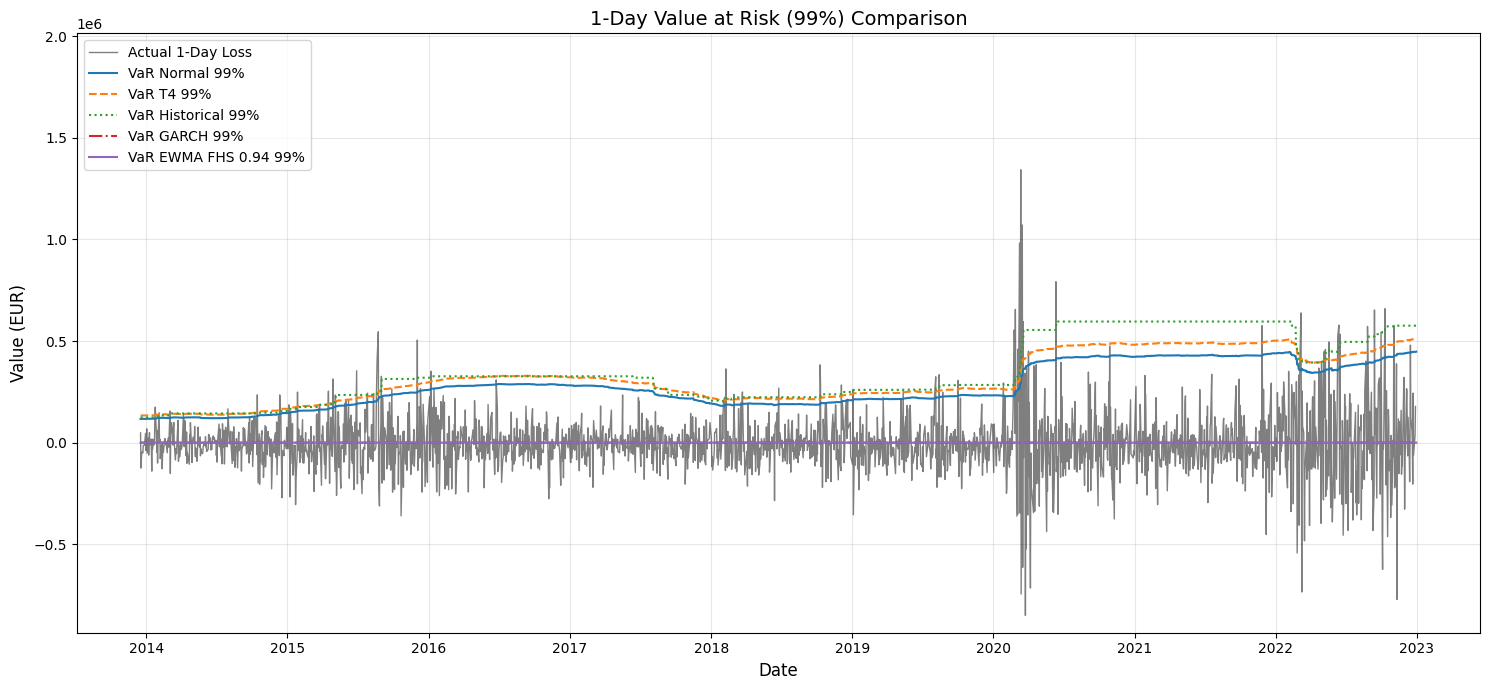

In [12]:
plt.figure(figsize=(15, 7))

# Select alpha level for plotting (e.g., 99%)
alpha_plot_idx = 1 # Index 1 corresponds to 0.99 in vAlpha
alpha_plot_label = int(vAlpha[alpha_plot_idx] * 100)

# Align actual losses with VaR results dates
plot_dates = var_results_df['Date']
actual_losses_aligned = main_df.set_index('Date').loc[plot_dates]['Portfolio_loss']

# Plot actual losses
plt.plot(plot_dates, actual_losses_aligned, label='Actual 1-Day Loss', color='black', alpha=0.5, linewidth=1)

# Plot VaR from different methods
plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR Normal']], label=f'VaR Normal {alpha_plot_label}%', linestyle='-')
plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR T4']], label=f'VaR T4 {alpha_plot_label}%', linestyle='--')
plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR Historical']], label=f'VaR Historical {alpha_plot_label}%', linestyle=':')
plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR GARCH']], label=f'VaR GARCH {alpha_plot_label}%', linestyle='-.')
plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR EWMA FHS 0.94']], label=f'VaR EWMA FHS 0.94 {alpha_plot_label}%', linestyle='-')
# plt.plot(plot_dates, [v[alpha_plot_idx] for v in var_results_df['VaR EWMA FHS 0.97']], label=f'VaR EWMA FHS 0.97 {alpha_plot_label}%', linestyle='--')

plt.title(f'1-Day Value at Risk ({alpha_plot_label}%) Comparison', fontsize=14)
plt.ylabel('Value (EUR)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(bottom=min(0, actual_losses_aligned.min()*1.1), top=actual_losses_aligned.max()*1.5) # Adjust y-axis limits
plt.tight_layout()
plt.show()

### 1-Day ES Comparison

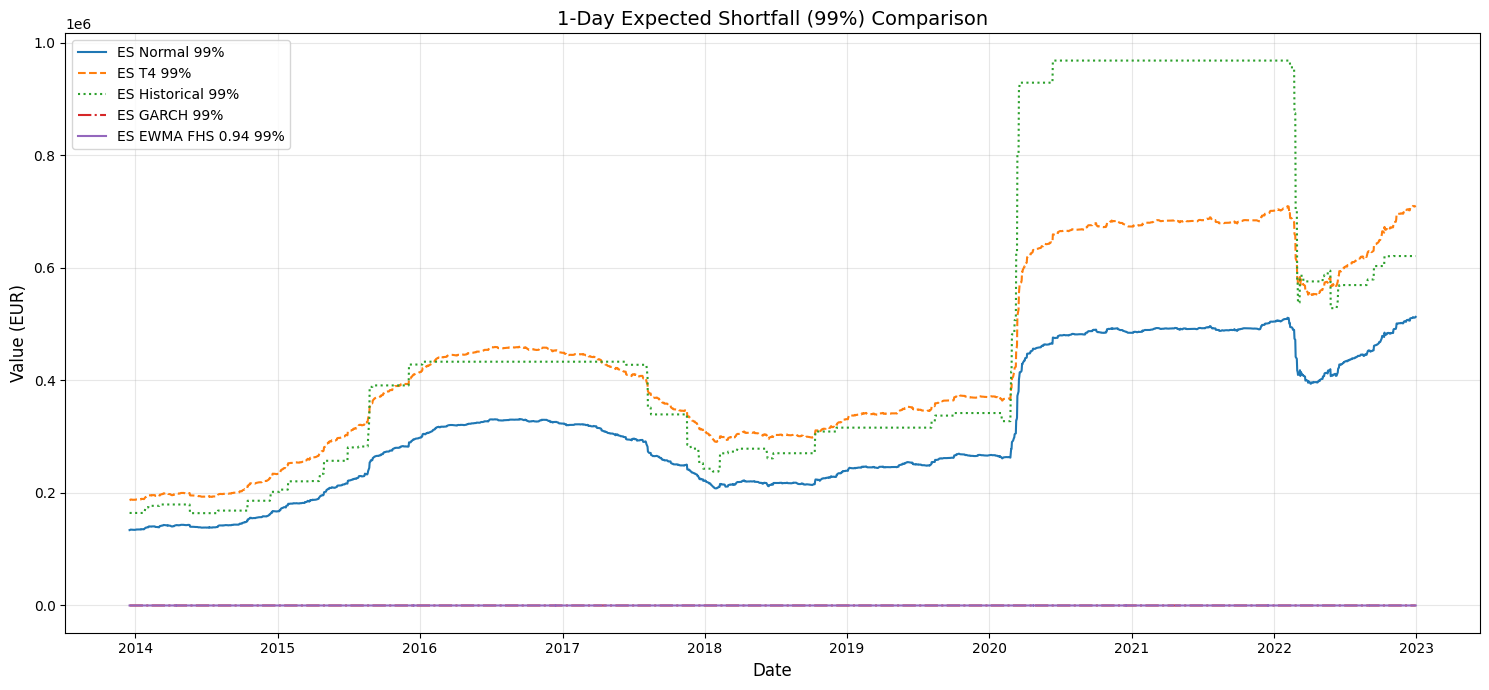

In [13]:
plt.figure(figsize=(15, 7))

# Select alpha level for plotting (e.g., 99%)
alpha_plot_idx = 1 # Index 1 corresponds to 0.99 in vAlpha
alpha_plot_label = int(vAlpha[alpha_plot_idx] * 100)

# Align actual losses with ES results dates
plot_dates = es_results_df['Date']
actual_losses_aligned = main_df.set_index('Date').loc[plot_dates]['Portfolio_loss']

# Plot actual losses (optional, can make plot busy)
# plt.plot(plot_dates, actual_losses_aligned, label='Actual 1-Day Loss', color='black', alpha=0.3, linewidth=1)

# Plot ES from different methods
plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES Normal']], label=f'ES Normal {alpha_plot_label}%', linestyle='-')
plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES T4']], label=f'ES T4 {alpha_plot_label}%', linestyle='--')
plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES Historical']], label=f'ES Historical {alpha_plot_label}%', linestyle=':')
plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES GARCH']], label=f'ES GARCH {alpha_plot_label}%', linestyle='-.')
plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES EWMA FHS 0.94']], label=f'ES EWMA FHS 0.94 {alpha_plot_label}%', linestyle='-')
# plt.plot(plot_dates, [e[alpha_plot_idx] for e in es_results_df['ES EWMA FHS 0.97']], label=f'ES EWMA FHS 0.97 {alpha_plot_label}%', linestyle='--')

plt.title(f'1-Day Expected Shortfall ({alpha_plot_label}%) Comparison', fontsize=14)
plt.ylabel('Value (EUR)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
# plt.ylim(bottom=min(0, actual_losses_aligned.min()*1.1)) # Adjust y-axis limits if needed
plt.tight_layout()
plt.show()

### Multi-Day Historical VaR Plots

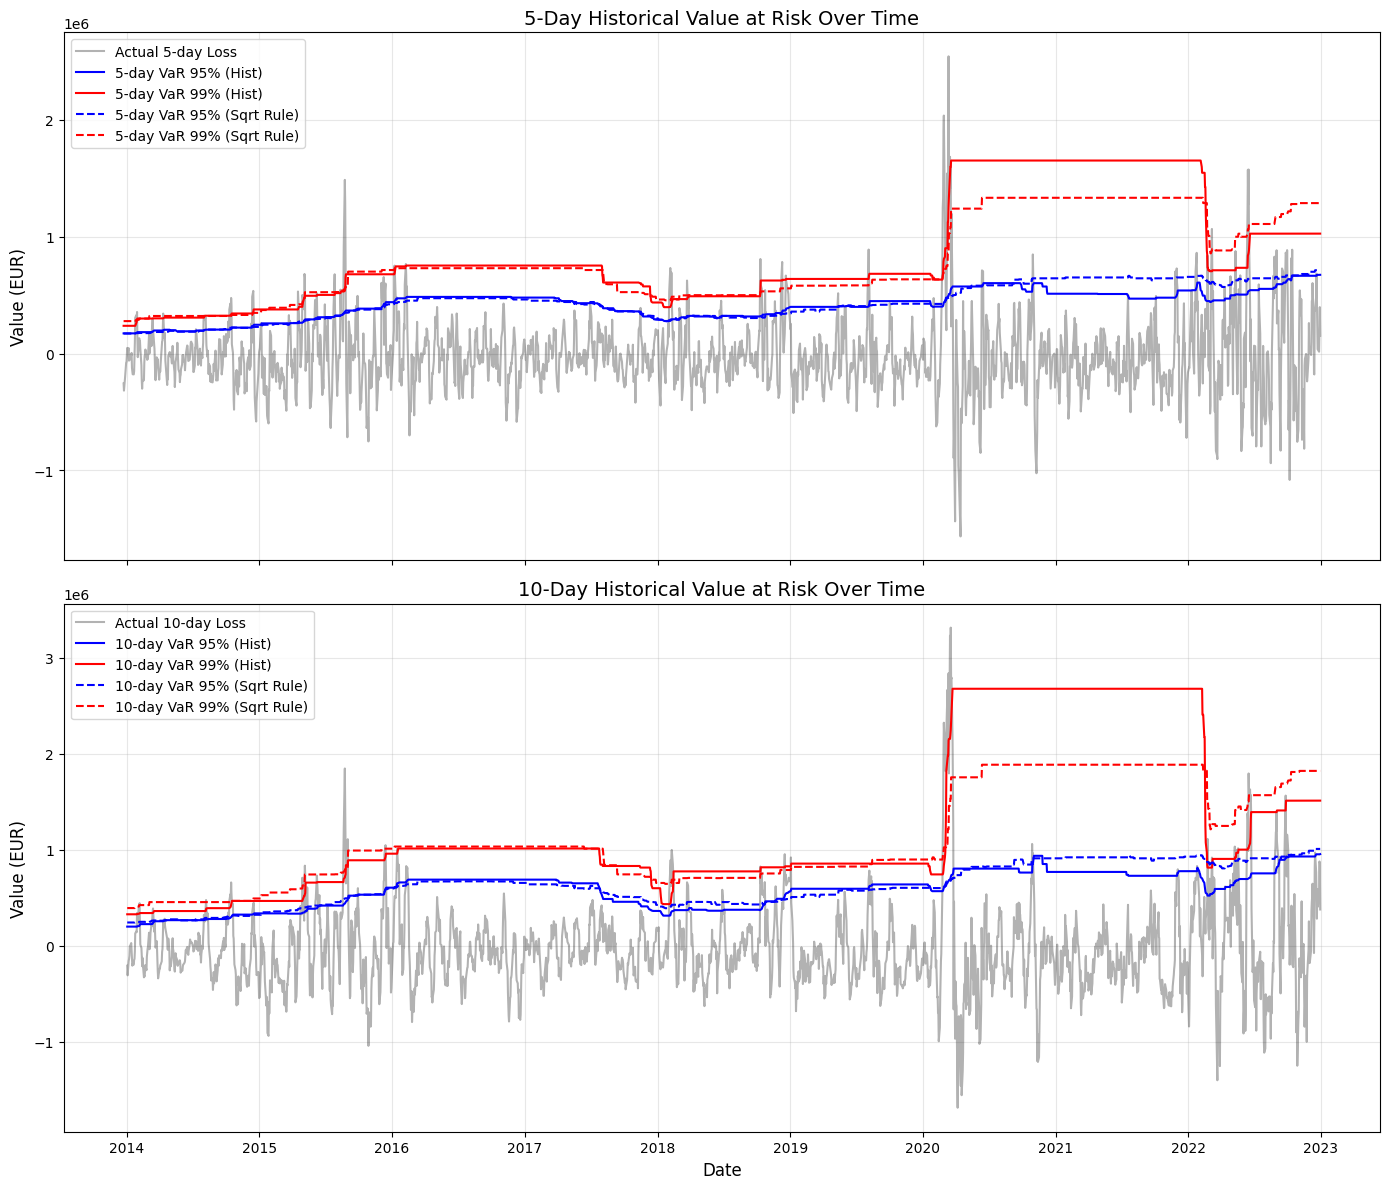

In [14]:
# Plotting 5-day and 10-day Historical VaR (using the results from calculate_multiday_var)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- 5-Day Plot ---
if not var_5d_hist_df.empty:
    var5d_hist_95 = [row[0] for row in var_5d_hist_df['VaR_5d_Hist']]
    var5d_hist_99 = [row[1] for row in var_5d_hist_df['VaR_5d_Hist']]
    var5d_sqrt_95 = [row[0] for row in var_5d_hist_df['VaR_5d_Sqrt']]
    var5d_sqrt_99 = [row[1] for row in var_5d_hist_df['VaR_5d_Sqrt']]
    
    ax1.plot(var_5d_hist_df['Date'], var_5d_hist_df['Portfolio_loss_5d'], 'k-', alpha=0.3, label='Actual 5-day Loss')
    ax1.plot(var_5d_hist_df['Date'], var5d_hist_95, 'b-', label='5-day VaR 95% (Hist)')
    ax1.plot(var_5d_hist_df['Date'], var5d_hist_99, 'r-', label='5-day VaR 99% (Hist)')
    ax1.plot(var_5d_hist_df['Date'], var5d_sqrt_95, 'b--', label='5-day VaR 95% (Sqrt Rule)')
    ax1.plot(var_5d_hist_df['Date'], var5d_sqrt_99, 'r--', label='5-day VaR 99% (Sqrt Rule)')
    ax1.set_title('5-Day Historical Value at Risk Over Time', fontsize=14)
    ax1.set_ylabel('Value (EUR)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

# --- 10-Day Plot ---
if not var_10d_hist_df.empty:
    var10d_hist_95 = [row[0] for row in var_10d_hist_df['VaR_10d_Hist']]
    var10d_hist_99 = [row[1] for row in var_10d_hist_df['VaR_10d_Hist']]
    var10d_sqrt_95 = [row[0] for row in var_10d_hist_df['VaR_10d_Sqrt']]
    var10d_sqrt_99 = [row[1] for row in var_10d_hist_df['VaR_10d_Sqrt']]
    
    ax2.plot(var_10d_hist_df['Date'], var_10d_hist_df['Portfolio_loss_10d'], 'k-', alpha=0.3, label='Actual 10-day Loss')
    ax2.plot(var_10d_hist_df['Date'], var10d_hist_95, 'b-', label='10-day VaR 95% (Hist)')
    ax2.plot(var_10d_hist_df['Date'], var10d_hist_99, 'r-', label='10-day VaR 99% (Hist)')
    ax2.plot(var_10d_hist_df['Date'], var10d_sqrt_95, 'b--', label='10-day VaR 95% (Sqrt Rule)')
    ax2.plot(var_10d_hist_df['Date'], var10d_sqrt_99, 'r--', label='10-day VaR 99% (Sqrt Rule)')
    ax2.set_title('10-Day Historical Value at Risk Over Time', fontsize=14)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Value (EUR)', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Backtesting VaR and ES (1-Day)

In [ ]:
def calculate_violations(actual_losses, var_predictions):
    """Checks for VaR violations."""
    # Ensure inputs are aligned Series
    actual, predicted = actual_losses.align(var_predictions, join='inner')
    return actual > predicted

def backtest_var(violations, alpha, dates):
    """Compares actual vs. expected VaR violations yearly."""
    if not isinstance(violations, pd.Series):
        violations = pd.Series(violations, index=dates)
    elif violations.index.name != 'Date': # Ensure index is Date for grouping
         violations = violations.set_index(dates)
            
    violations_df = pd.DataFrame({'Violations': violations, 'Year': violations.index.year})
    yearly_violations = violations_df.groupby('Year')['Violations'].sum()
    yearly_counts = violations_df.groupby('Year')['Violations'].count()
    
    expected_violations = yearly_counts * (1 - alpha)
    
    summary = pd.DataFrame({
        'Actual Violations': yearly_violations,
        'Expected Violations': expected_violations.round(2),
        'Violation Rate (%)': (yearly_violations / yearly_counts * 100).round(2),
        'Expected Rate (%)': (1 - alpha) * 100,
        'Total Observations': yearly_counts
    })
    # Add totals
    summary.loc['Total'] = summary.sum()
    summary.loc['Total', 'Violation Rate (%)'] = (summary.loc['Total', 'Actual Violations'] / summary.loc['Total', 'Total Observations'] * 100).round(2)
    summary.loc['Total', 'Expected Rate (%)'] = (1 - alpha) * 100
    return summary

def backtest_es(actual_losses, violations, es_predictions, dates):
    """Compares actual average shortfall vs. predicted ES yearly."""
    # Align all three series by chaining align (align two at a time)
    actual_losses_aligned, violations_aligned = actual_losses.align(violations, join='inner')
    actual_losses_aligned, es_predictions_aligned = actual_losses_aligned.align(es_predictions, join='inner')
    violations_aligned = violations_aligned.loc[actual_losses_aligned.index]
    
    results_df = pd.DataFrame({
        'Actual_Loss': actual_losses_aligned,
        'Violation': violations_aligned,
        'Predicted_ES': es_predictions_aligned,
        'Year': actual_losses_aligned.index.year
    })
    
    # Filter for violations
    violation_data = results_df[results_df['Violation']].copy()
    violation_data['Shortfall'] = violation_data['Actual_Loss']
    
    # Calculate yearly averages
    yearly_avg_actual_shortfall = violation_data.groupby('Year')['Shortfall'].mean()
    yearly_avg_predicted_es = violation_data.groupby('Year')['Predicted_ES'].mean()
    yearly_violation_count = violation_data.groupby('Year').size()

    summary = pd.DataFrame({
        'Avg Actual Shortfall': yearly_avg_actual_shortfall.round(2),
        'Avg Predicted ES': yearly_avg_predicted_es.round(2),
        'Difference (Actual - Pred)': (yearly_avg_actual_shortfall - yearly_avg_predicted_es).round(2),
        'Violation Count': yearly_violation_count
    })
    # Add totals/averages
    if not summary.empty:
        total_violations = summary['Violation Count'].sum()
        avg_shortfall_total = violation_data['Shortfall'].mean() if total_violations > 0 else np.nan
        avg_es_total = violation_data['Predicted_ES'].mean() if total_violations > 0 else np.nan
        summary.loc['Average/Total'] = [avg_shortfall_total.round(2), avg_es_total.round(2), (avg_shortfall_total - avg_es_total).round(2) if total_violations > 0 else np.nan, total_violations]
    return summary

def plot_violations(violations, dates, title):
    """Plots VaR violations over time."""
    plt.figure(figsize=(15, 3))
    violation_points = violations[violations == True]
    plt.plot(dates, violations.astype(int), 'k|', markersize=5, alpha=0.1, label='_nolegend_')
    if not violation_points.empty:
        plt.plot(violation_points.index, np.ones(len(violation_points)), 'ro', markersize=4, alpha=0.7, label='Violation')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Violation (1=Yes)')
    plt.yticks([0, 1])
    plt.ylim([-0.1, 1.1])
    plt.grid(axis='y', linestyle='--')
    plt.legend()
    plt.show()

def run_backtesting_consolidated(main_df, var_results_df, es_results_df, vAlpha):
    """Runs the backtesting process for consolidated VaR and ES models."""
    # Align main_df with var/es results (which start after the initial window)
    backtest_dates = var_results_df['Date']
    if backtest_dates.empty:
        print("No results to backtest.")
        return
        
    backtest_data = main_df.set_index('Date').reindex(backtest_dates)
    actual_losses = backtest_data['Portfolio_loss'].dropna()
    
    # Ensure results DFs are indexed by Date for alignment
    var_results_indexed = var_results_df.set_index('Date')
    es_results_indexed = es_results_df.set_index('Date')
    
    alpha_indices = {alpha_val: idx for idx, alpha_val in enumerate(vAlpha)}

    # Iterate through models (columns in var_results_df/es_results_df)
    model_cols = [col for col in var_results_indexed.columns if col.startswith('VaR')] # Use VaR cols to identify models

    for model_col_name in model_cols:
        model_base_name = model_col_name.replace('VaR ', '') # e.g., 'Normal', 'T4', 'Historical', 'GARCH', 'EWMA FHS 0.94'
        es_col_name = f'ES {model_base_name}'
        
        print(f"\n{'='*20} Backtesting for Model: {model_base_name} {'='*20}")
        
        if es_col_name not in es_results_indexed.columns:
            print(f"  Warning: No matching ES column '{es_col_name}' found. Skipping ES backtest.")
            es_preds_list = None
        else:
             es_preds_list = es_results_indexed[es_col_name].tolist()
             
        var_preds_list = var_results_indexed[model_col_name].tolist()
        
        for alpha in vAlpha:
            alpha_idx = alpha_indices[alpha]
            print(f"\n--- Confidence Level: {alpha*100}% --- ")
            
            # Extract predictions for the specific alpha
            try:
                # Handle cases where predictions might not be arrays (e.g., if only one alpha was calculated)
                if isinstance(var_preds_list[0], (list, np.ndarray)):
                    var_predictions = pd.Series([p[alpha_idx] for p in var_preds_list], index=backtest_dates)
                else: # Assume scalar prediction if not array
                    var_predictions = pd.Series(var_preds_list, index=backtest_dates)
                    
                if es_preds_list:
                    if isinstance(es_preds_list[0], (list, np.ndarray)):
                        es_predictions = pd.Series([p[alpha_idx] for p in es_preds_list], index=backtest_dates)
                    else:
                        es_predictions = pd.Series(es_preds_list, index=backtest_dates)
                else:
                    es_predictions = None
            except (TypeError, IndexError, ValueError) as e:
                print(f"  Error extracting predictions for alpha={alpha}: {e}. Skipping.")
                continue
                
            # Align actual losses and predictions
            aligned_losses, aligned_var = actual_losses.align(var_predictions, join='inner')
            if aligned_losses.empty:
                print("  No aligned data for backtesting.")
                continue
                
            # 1. Calculate Violations
            violations = calculate_violations(aligned_losses, aligned_var)
            
            # 2. Backtest VaR
            var_summary = backtest_var(violations, alpha, aligned_losses.index)
            print("\nVaR Backtest Summary (Yearly):")
            display(var_summary)
            
            # 3. Backtest ES
            if es_predictions is not None:
                # Align all three series needed for ES backtesting pairwise
                aligned_losses_temp, aligned_violations_temp = actual_losses.align(violations, join='inner')
                aligned_losses_es, aligned_es = aligned_losses_temp.align(es_predictions, join='inner')
                # Get the violations series aligned to the final index
                _, aligned_violations_es = aligned_violations_temp.align(aligned_es, join='inner')
                
                if not aligned_losses_es.empty:
                    es_summary = backtest_es(aligned_losses_es, aligned_violations_es, aligned_es, aligned_losses_es.index)
                    print("\nES Backtest Summary (Yearly):")
                    display(es_summary)
                else:
                    print("\nES Backtest: No aligned data for ES.")
            
            # 4. Plot Violations
            plot_violations(violations, aligned_losses.index, f'VaR Violations for {model_base_name} (alpha={alpha})')

## Execute Backtesting

In [16]:
# Call the backtesting function with the consolidated results
run_backtesting_consolidated(main_df, var_results_df, es_results_df, vAlpha)


==================== Backtesting for Model: Normal ====================

--- Confidence Level: 95.0% --- 

VaR Backtest Summary (Yearly):


,Actual Violations,Expected Violations,Violation Rate (%),Expected Rate (%),Total Observations
Year,,,,,
2013,0.000000,0.450000,0.000000,5.000000,9.000000
2014,28.000000,12.750000,10.980000,5.000000,255.000000
2015,39.000000,12.700000,15.350000,5.000000,254.000000
2016,9.000000,12.850000,3.500000,5.000000,257.000000
2017,3.000000,12.750000,1.180000,5.000000,255.000000
2018,30.000000,12.650000,11.860000,5.000000,253.000000
2019,16.000000,12.650000,6.320000,5.000000,253.000000
2020,24.000000,12.750000,9.410000,5.000000,255.000000
2021,4.000000,12.850000,1.560000,5.000000,257.000000


TypeError: NDFrame.align() got multiple values for argument 'join'

### Backtesting Interpretation

Review the tables and plots above:

*   **VaR Backtest:** Compare 'Actual Violations' to 'Expected Violations' or 'Actual Rate (%)' to 'Expected Rate (%)' each year and overall. Significant deviations might indicate issues with the VaR model's calibration. If actual violations consistently exceed expected, the model underestimates risk. If they are consistently lower, it might be too conservative.
*   **ES Backtest:** Compare 'Avg Actual Shortfall' to 'Avg Predicted ES'. If the actual average shortfall during violations is consistently higher than the predicted ES ('Difference' > 0), the model underestimates the severity of tail losses.
*   **Violation Plots:** Look for patterns. Ideally, violations should be randomly distributed. Clustering of violations suggests the model fails to adapt quickly to changing market volatility (violation dependence).

# Stress Testing

(Keeping the original Stress Testing section - Note: This uses a different calculation path (`main_modified`) than the consolidated analysis above. Results might differ slightly due to implementation details.)

In [ ]:
def select_stress_periods(df, num_periods=5, max_duration=4, min_separation=20, data_start_offset=500):
    """Selects random start indices for stress periods."""
    potential_starts = list(range(data_start_offset, len(df) - max_duration))
    if not potential_starts:
        print("Warning: No potential start dates for stress testing after offset and duration.")
        return []
    selected_indices = []
    attempts = 0
    max_attempts = num_periods * 20 # Prevent infinite loops
    
    while len(selected_indices) < num_periods and attempts < max_attempts:
        start_index = random.choice(potential_starts)
        duration = random.randint(1, max_duration)
        valid = True
        # Check for overlap/proximity with already selected periods
        for existing_start, existing_duration in selected_indices:
            if abs(start_index - existing_start) < min_separation:
                valid = False
                break
        if valid:
            selected_indices.append((start_index, duration))
        attempts += 1
        
    if len(selected_indices) < num_periods:
        print(f"Warning: Could only select {len(selected_indices)} out of {num_periods} stress periods.")
        
    return selected_indices

def recalculate_portfolio_metrics(df_stressed):
    """Recalculates all derived portfolio metrics after stressing base data."""
    df_recalc = df_stressed.copy()
    
    # --- Recalculate Bond Values ---
    days_per_annum = 365
    interest_bond_initial = 1500000 # Find the actual initial value if different
    interest_bond_vector = np.zeros(len(df_recalc))
    interest_bond_profit_vector = np.zeros(len(df_recalc))
    interest_bond_loss_vector = np.zeros(len(df_recalc))
    daily_rates = np.zeros(len(df_recalc))
    yield_col_name = 'Yield curve spot rate, 10-year maturity - Government bond'
    
    if len(df_recalc) > 0:
        # Find the actual starting value from the original calculation if possible
        # Or assume the initial value applies to the first row
        interest_bond_vector[0] = df_recalc['Interest_Bond'].iloc[0] if 'Interest_Bond' in df_recalc.columns else interest_bond_initial
        
        for i in range(len(df_recalc)):
            if yield_col_name in df_recalc.columns:
                daily_rate = (((df_recalc[yield_col_name].iloc[i] + 1.5) / days_per_annum) * (7/5)) / 100
                daily_rates[i] = daily_rate
                if i > 0:
                    previous_value = interest_bond_vector[i-1]
                    current_value = previous_value * (1 + daily_rate)
                    interest_bond_vector[i] = current_value
                    change = current_value - previous_value
                    interest_bond_profit_vector[i] = change
                    interest_bond_loss_vector[i] = -change
                else: # First day calculation
                     daily_rates[0] = (((df_recalc[yield_col_name].iloc[0] + 1.5) / days_per_annum) * (7/5)) / 100
            else:
                print(f"Warning: Column '{yield_col_name}' not found during recalculation.")
                daily_rates[i] = 0
                if i > 0: interest_bond_vector[i] = interest_bond_vector[i-1]
                
        df_recalc['Interest_Bond'] = interest_bond_vector
        df_recalc['Interest_Bond_Profit'] = interest_bond_profit_vector
        df_recalc['Interest_Bond_Loss'] = interest_bond_loss_vector
        df_recalc['Interest_Bond_daily_rate'] = daily_rates
    
    # --- Recalculate Investment Values ---
    weights_dict_recalc = {'S&P500': 0.4, 'DAX40': 0.3, 'NIKKEI': 0.15, 'EU-BOND': 0.15}
    starting_investment_recalc = 10000000
    starting_date_recalc = '2012-01-04'
    start_idx_recalc = df_recalc[df_recalc['Date'] == starting_date_recalc].index
    
    if not start_idx_recalc.empty:
        start_idx_recalc = start_idx_recalc[0]
        # Use initial investment values calculated earlier if available, or recalculate
        # This assumes the stress doesn't affect the very first day's setup
        df_recalc.loc[start_idx_recalc, 'SP500_Investment'] = invested_amount_SP500_local
        df_recalc.loc[start_idx_recalc, 'DAX40_Investment'] = invested_amount_DAX40_local
        df_recalc.loc[start_idx_recalc, 'NIKKEI_Investment'] = invested_amount_NIKKEI_local
        df_recalc.loc[start_idx_recalc, 'EU_BOND_Investment'] = df_recalc.loc[start_idx_recalc, 'Interest_Bond']
        
        for i in range(start_idx_recalc + 1, len(df_recalc)):
            df_recalc.loc[i, 'SP500_Investment'] = df_recalc.loc[i-1, 'SP500_Investment'] * (1 + df_recalc.loc[i, 'C_S&P500_Returns'])
            df_recalc.loc[i, 'DAX40_Investment'] = df_recalc.loc[i-1, 'DAX40_Investment'] * (1 + df_recalc.loc[i, 'C_Dax40_Returns'])
            df_recalc.loc[i, 'NIKKEI_Investment'] = df_recalc.loc[i-1, 'NIKKEI_Investment'] * (1 + df_recalc.loc[i, 'C_Nikkei_Returns'])
            df_recalc.loc[i, 'EU_BOND_Investment'] = df_recalc.loc[i, 'Interest_Bond'] # Bond value is directly taken
    else:
        print("Warning: Starting date not found for investment recalculation.")
        # Need a fallback if start date is missing

    # --- Recalculate Portfolio Value/Change/Loss ---
    df_recalc['Portfolio_Value_EUR'] = (
        df_recalc['SP500_Investment'].fillna(0) * df_recalc['USD/EUR'] +
        df_recalc['DAX40_Investment'].fillna(0) +
        df_recalc['NIKKEI_Investment'].fillna(0) * df_recalc['JPY/EUR'] +
        df_recalc['EU_BOND_Investment'].fillna(0)
    )
    if not start_idx_recalc.empty:
         df_recalc.loc[start_idx_recalc, 'Portfolio_Value_EUR'] = starting_investment_recalc
         
    df_recalc['Portfolio_Change_EUR'] = df_recalc['Portfolio_Value_EUR'].diff()
    df_recalc['Portfolio_loss'] = -df_recalc['Portfolio_Change_EUR']
    
    if not start_idx_recalc.empty:
        df_recalc.loc[start_idx_recalc, 'Portfolio_Change_EUR'] = 0.0
        df_recalc.loc[start_idx_recalc, 'Portfolio_loss'] = 0.0
    elif len(df_recalc) > 0:
        df_recalc.loc[df_recalc.index[0], 'Portfolio_Change_EUR'] = 0.0
        df_recalc.loc[df_recalc.index[0], 'Portfolio_loss'] = 0.0
            
    # --- Recalculate Portfolio Daily Returns ---
    df_recalc['Portfolio_Daily_Return'] = df_recalc['Portfolio_Value_EUR'].pct_change()
    if not start_idx_recalc.empty:
        df_recalc.loc[start_idx_recalc, 'Portfolio_Daily_Return'] = 0.0
    elif len(df_recalc) > 0:
         df_recalc.loc[df_recalc.index[0], 'Portfolio_Daily_Return'] = 0.0
    
    return df_recalc.fillna(0) # Fill NaNs that might arise, e.g., in early rows

In [ ]:
def stress_equity(df, periods, shock_factor):
    """Applies additive shock to equity returns during specified periods."""
    df_stressed = df.copy()
    equity_cols = ['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns']
    for start_index, duration in periods:
        for i_loc in range(start_index, min(start_index + duration, len(df_stressed))):
            idx = df_stressed.index[i_loc] # Get actual index label
            for col in equity_cols:
                df_stressed.loc[idx, col] = df_stressed.loc[idx, col] + shock_factor
    return df_stressed

def stress_currency(df, periods, shock_factor_major, shock_factor_other):
    """Applies multiplicative shock to currency rates during specified periods."""
    df_stressed = df.copy()
    major_cols = ['USD/EUR', 'JPY/EUR']
    for start_index, duration in periods:
        for i_loc in range(start_index, min(start_index + duration, len(df_stressed))):
            idx = df_stressed.index[i_loc]
            for col in major_cols:
                df_stressed.loc[idx, col] = df_stressed.loc[idx, col] * shock_factor_major
    return df_stressed

def stress_commodity(df, periods, shock_factor):
    """Applies additive shock to equity returns as a proxy for commodity stress."""
    return stress_equity(df, periods, shock_factor)

def stress_interest_rate(df, periods, shock_shift):
    """Applies additive shift to interest rates during specified periods."""
    df_stressed = df.copy()
    rate_col = 'Yield curve spot rate, 10-year maturity - Government bond'
    for start_index, duration in periods:
        for i_loc in range(start_index, min(start_index + duration, len(df_stressed))):
            idx = df_stressed.index[i_loc]
            df_stressed.loc[idx, rate_col] = max(-1.0, df_stressed.loc[idx, rate_col] + shock_shift)
    # Recalculate all dependent metrics after stressing interest rates
    df_stressed = recalculate_portfolio_metrics(df_stressed)
    return df_stressed

In [ ]:
# Helper function to calculate loss stats needed by original main()
def calculate_daily_loss_variables(time_window, current_date):
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

# Helper function for historical var/es needed by original main()
def calculate_historical_var_es(window, current_date, vAlpha):
    historical_losses = window['Portfolio_loss'].dropna()
    if len(historical_losses) < 2: return {'Date': current_date, 'VaR Historical': np.full(len(vAlpha), np.nan), 'ES Historical': np.full(len(vAlpha), np.nan)}
    sorted_losses = np.sort(historical_losses)
    var_hist = np.percentile(sorted_losses, 100*vAlpha)
    es_hist = []
    for i, alpha in enumerate(vAlpha):
        es_hist.append(sorted_losses[sorted_losses >= var_hist[i]].mean())
    return {'Date': current_date, 'VaR Historical': var_hist, 'ES Historical': es_hist}

# Helper function for var/cov needed by original main()
def calculate_var_cov(window, current_date, vAlpha, mean_loss, portfolio_std_loss, df=0):
    var_result = VaR(vAlpha, mean_loss, portfolio_std_loss, df=df)
    es_result = ES(vAlpha, mean_loss, portfolio_std_loss, df=df)
    dist_label = "Normal" if df == 0 else f"T{df}"
    return {'Date': current_date, f'VaR {dist_label}': var_result, f'ES {dist_label}': es_result}

def run_stress_scenario(original_df, stress_type, shock_params, scenario_name):
    """Runs a single stress scenario and recalculates VaR/ES using the original main logic."""
    print(f"--- Running Stress Scenario: {scenario_name} ---")
    df_stressed = original_df.copy()
    
    periods = select_stress_periods(df_stressed, num_periods=shock_params.get('num_repeats', 5), 
                                    max_duration=shock_params.get('duration', 4))
    if not periods: return pd.DataFrame(), pd.DataFrame() # Skip if no periods selected
    
    if stress_type == 'equity':
        df_stressed = stress_equity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed)
    elif stress_type == 'currency':
        df_stressed = stress_currency(df_stressed, periods, shock_params['shock_major'], shock_params.get('shock_other', 1.0))
        df_stressed = recalculate_portfolio_metrics(df_stressed)
    elif stress_type == 'commodity':
        df_stressed = stress_commodity(df_stressed, periods, shock_params['shock'])
        df_stressed = recalculate_portfolio_metrics(df_stressed)
    elif stress_type == 'interest_rate':
        df_stressed = stress_interest_rate(df_stressed, periods, shock_params['shift'])
        # Recalculation is handled within stress_interest_rate
    else:
        raise ValueError(f"Unknown stress type: {stress_type}")
        
    # Re-run VaR/ES calculation using the existing main() function logic (adapted)
    def main_stress_calc(input_df):
        VaR_results = []
        ES_results = []
        time_window = input_df[(input_df['Date'] >= '2012-01-05') & (input_df['Date'] <= '2021-12-31')].reset_index(drop=True)
        vAlpha_stress = np.array([0.95, 0.99])
        sample_size_stress = 500
        degrees_of_freedom_stress = [0, 3, 4, 5, 6]
        
        if len(time_window) <= sample_size_stress:
             print(f"Warning: Not enough data ({len(time_window)}) for sample size {sample_size_stress} in stressed scenario.")
             return pd.DataFrame(), pd.DataFrame()
             
        for i in range(sample_size_stress, len(time_window)):
            window = time_window.iloc[i - sample_size_stress:i]
            current_date = time_window.iloc[i]['Date']
            loss_stats = calculate_daily_loss_variables(window, current_date)
            mean_loss = loss_stats["Portfolio_mean_loss"]
            portfolio_std_loss = loss_stats["Portfolio_std_loss"]
            var_row = {'Date': current_date}
            es_row = {'Date': current_date}
            for df in degrees_of_freedom_stress:
                results = calculate_var_cov(window, current_date, vAlpha_stress, mean_loss, portfolio_std_loss, df)
                dist_label = "Normal" if df == 0 else f"T{df}"
                var_row[f'VaR {dist_label}'] = results[f'VaR {dist_label}']
                es_row[f'ES {dist_label}'] = results[f'ES {dist_label}']
            hist_results = calculate_historical_var_es(window, current_date, vAlpha_stress)
            var_row['VaR Historical'] = hist_results['VaR Historical']
            es_row['ES Historical'] = hist_results['ES Historical']
            VaR_results.append(var_row)
            ES_results.append(es_row)
        return pd.DataFrame(VaR_results), pd.DataFrame(ES_results)
        
    stressed_var, stressed_es = main_stress_calc(df_stressed)
    print(f"--- Finished Stress Scenario: {scenario_name} ---")
    return stressed_var, stressed_es

In [ ]:
def stress_testing_main(original_df, baseline_var, baseline_es):
    """Defines and runs all stress test scenarios."""
    scenarios = {
        # Equity Stresses
        'Equity +20%': {'type': 'equity', 'params': {'shock': 0.20}},
        'Equity -20%': {'type': 'equity', 'params': {'shock': -0.20}},
        'Equity +40%': {'type': 'equity', 'params': {'shock': 0.40}},
        'Equity -40%': {'type': 'equity', 'params': {'shock': -0.40}},
        # Currency Stresses (Major +/- 10%)
        'Currency +10%': {'type': 'currency', 'params': {'shock_major': 1.10}},
        'Currency -10%': {'type': 'currency', 'params': {'shock_major': 0.90}},
        # Commodity Stresses (Proxy via Equity)
        'Commodity +20%': {'type': 'commodity', 'params': {'shock': 0.20}},
        'Commodity -20%': {'type': 'commodity', 'params': {'shock': -0.20}},
        'Commodity +40%': {'type': 'commodity', 'params': {'shock': 0.40}},
        'Commodity -40%': {'type': 'commodity', 'params': {'shock': -0.40}},
        # Interest Rate Stresses (Absolute Shift)
        'Interest Rate +2%': {'type': 'interest_rate', 'params': {'shift': 2.0}},
        'Interest Rate -2%': {'type': 'interest_rate', 'params': {'shift': -2.0}},
        'Interest Rate +3%': {'type': 'interest_rate', 'params': {'shift': 3.0}},
        'Interest Rate -3%': {'type': 'interest_rate', 'params': {'shift': -3.0}},
    }
    
    results_summary = {}
    
    # Use the Historical results from the baseline consolidated run
    baseline_var_hist = baseline_var[['Date', 'VaR Historical']].set_index('Date')
    baseline_es_hist = baseline_es[['Date', 'ES Historical']].set_index('Date')
    
    for name, config in scenarios.items():
        stressed_var, stressed_es = run_stress_scenario(original_df, config['type'], config['params'], name)
        
        if stressed_var.empty or stressed_es.empty:
            results_summary[name] = {'Error': 'Calculation failed or insufficient data'}
            continue
            
        # Compare stressed results (Historical) to baseline (Historical)
        stressed_var_hist = stressed_var[['Date', 'VaR Historical']].set_index('Date')
        stressed_es_hist = stressed_es[['Date', 'ES Historical']].set_index('Date')
        
        # Align baseline and stressed results by date
        aligned_base_var, aligned_stressed_var = baseline_var_hist.align(stressed_var_hist, join='inner')
        aligned_base_es, aligned_stressed_es = baseline_es_hist.align(stressed_es_hist, join='inner')
        
        if aligned_base_var.empty or aligned_base_es.empty:
             results_summary[name] = {'Error': 'Alignment failed'}
             continue
             
        # Calculate average changes (using the aligned data)
        # Extract the 95% and 99% values (index 0 and 1)
        avg_baseline_var_95 = np.mean([v[0] for v in aligned_base_var['VaR Historical']])
        avg_baseline_var_99 = np.mean([v[1] for v in aligned_base_var['VaR Historical']])
        avg_stressed_var_95 = np.mean([v[0] for v in aligned_stressed_var['VaR Historical']])
        avg_stressed_var_99 = np.mean([v[1] for v in aligned_stressed_var['VaR Historical']])
        
        avg_baseline_es_95 = np.mean([e[0] for e in aligned_base_es['ES Historical']])
        avg_baseline_es_99 = np.mean([e[1] for e in aligned_base_es['ES Historical']])
        avg_stressed_es_95 = np.mean([e[0] for e in aligned_stressed_es['ES Historical']])
        avg_stressed_es_99 = np.mean([e[1] for e in aligned_stressed_es['ES Historical']])
        
        results_summary[name] = {
            'Avg Stressed VaR 95%': avg_stressed_var_95,
            'Avg Stressed VaR 99%': avg_stressed_var_99,
            'Avg VaR 95% Change': avg_stressed_var_95 - avg_baseline_var_95,
            'Avg VaR 99% Change': avg_stressed_var_99 - avg_baseline_var_99,
            'Avg Stressed ES 95%': avg_stressed_es_95,
            'Avg Stressed ES 99%': avg_stressed_es_99,
            'Avg ES 95% Change': avg_stressed_es_95 - avg_baseline_es_95,
            'Avg ES 99% Change': avg_stressed_es_99 - avg_baseline_es_99
        }
             
    return pd.DataFrame.from_dict(results_summary, orient='index')


## Execute Stress Testing

In [ ]:
# Run the main stress testing function
# Pass the baseline results from the consolidated run
stress_test_summary_df = stress_testing_main(main_df.copy(), var_results_df, es_results_df)

print("\nStress Test Summary:")
display(stress_test_summary_df.round(2))

### Stress Testing Interpretation

The table above shows the average change in the 95% and 99% Historical VaR and ES under different stress scenarios compared to the baseline.
- **Positive Change:** Indicates that the stress scenario increased the estimated risk (VaR/ES became larger positive numbers, representing larger potential losses).
- **Negative Change:** Indicates that the stress scenario decreased the estimated risk.

Analyze the magnitude of changes for different scenarios:
- Which scenarios cause the largest increase in risk?
- Are the impacts symmetrical (e.g., does a +20% equity shock have the opposite effect of a -20% shock)?
- How sensitive is the portfolio to interest rate shifts vs. equity or currency movements?